In [17]:
import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")
%matplotlib inline

Box Tiao Canonical Decomposition may find a place besides Engle-Granger and Johansen. This implementation has the feature of an interface for the regression model to determine the regression model that works best with the specific data at hand since the main problem with cointegration methods and BTCD is that they are prone to overfitting. This is why it is important to use a suitable regression model for your data. 

If you didn’t notice we used correlated random walks (discrete Brownian motions) as an example, the fact that the decomposition works with such data is proof of overfitting. For any not trivial linear combination of Brownian motions (even if they are correlated) is a rescaled Brownian motion which is by no means stationary nor trending for that matter, there is no cointegration for such combination. This is extremely important especially when cointegration is used to make predictions such as in statistical arbitrage trading applications. Sadly most of these methods will overfit the data, but hopefully, you can find the regression model that works best for you.

The predictability value λ is dependent on the regression model, so there is no meaningful comparison between lambdas calculated with different regression models, hence is not an absolute measure, it is only meaningful for comparison when using the same regression model.

### Create stationary and correlated timeseries

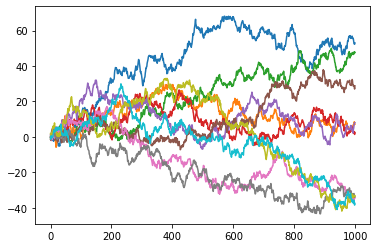

In [18]:
import Plib.Stats.BoxTiaoCanD as bt
import matplotlib.pyplot as plt
import pandas as pd 

brownian_motions = bt.get_brownian_motions(T=1_000, N=10)
plt.plot(brownian_motions)
plt.show()

#### Canonical Decomposition using Sklearn OLS with no intercept and max_lag=1

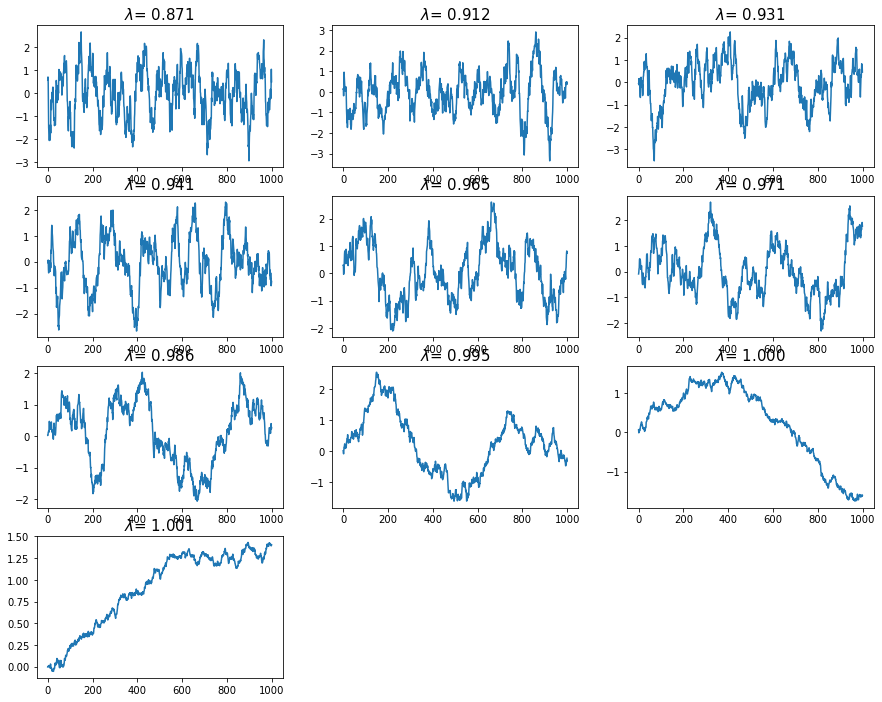

In [19]:
#--------------------------------
# regression model
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression(fit_intercept=False)

# use the regression model instance as argument for decompose function.
can_decomp_solution = bt.decompose(brownian_motions, regression_model, max_lag=1)

#--------------------------------
# plot

import numpy as np
import math
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
n_decomps = len(can_decomp_solution.lambdas)
n_graph_cols = 3
n_graph_rows = math.ceil(n_decomps / n_graph_cols)

def get_St(w_vec: np.ndarray, p_mat: np.ndarray) -> np.ndarray:
    from numpy import dot
    return dot(w_vec, p_mat.T)

for j in range(n_decomps):
    lambda_j = can_decomp_solution.lambdas[j]
    w_vec = can_decomp_solution.w_vecs[:, j]
    plt.subplot(n_graph_rows, n_graph_cols, j+1)
    S_t = get_St(w_vec, brownian_motions)
    plt.plot(S_t)
    subplot_title = r"$\lambda$= " + "{:.3f}".format(lambda_j)
    plt.gca().set_title(subplot_title, fontsize=15)
    
plt.show()

#### Sklearn’s elastic net and set max_lag to 9

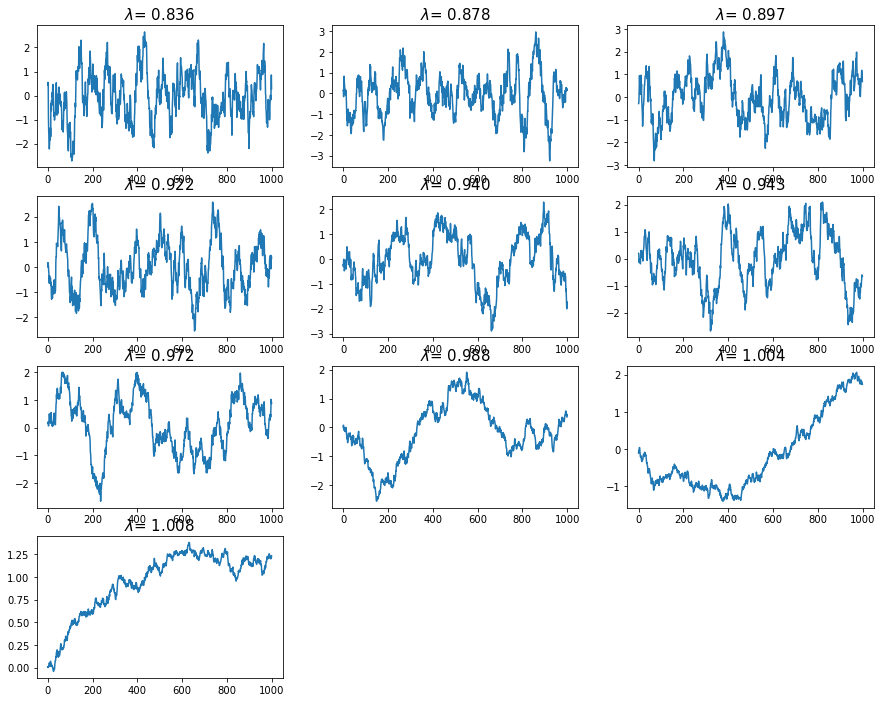

In [20]:
#--------------------------------
# regression model
from sklearn.linear_model import ElasticNet

regression_model = ElasticNet()

# use the regression model instance as argument for decompose function.
can_decomp_solution = bt.decompose(brownian_motions, regression_model, max_lag=9)


#--------------------------------
# plot

import math

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
n_decomps = len(can_decomp_solution.lambdas)
n_graph_cols = 3
n_graph_rows = math.ceil(n_decomps / n_graph_cols)

for j in range(n_decomps):
    lambda_j = can_decomp_solution.lambdas[j]
    w_vec = can_decomp_solution.w_vecs[:, j]
    plt.subplot(n_graph_rows, n_graph_cols, j+1)
    S_t = get_St(w_vec, brownian_motions)
    plt.plot(S_t)
    subplot_title = r"$\lambda$= " + "{:.3f}".format(lambda_j)
    plt.gca().set_title(subplot_title, fontsize=15)

plt.show()

When we increase the number of time series used to find cointegration relationships, in most cases, we see that the resulting time series keeps getting lower Dickey-Fuller test values, so it becomes more and more likely that such a time series is stationary.

For instance, if we use several Brownian motions (AR(1) unit root processes) it is easy to get Dickey-Fuller results of about -10. There is no way we can reject the hypothesis that such a time series is stationary. But a non-trivial linear combination of AR(1) unit root processes is again an AR(1) unit root process which by definition is non-stationary but not trending.

One may suppose that the more series fed to the model the better odds that the resulting time series is stationary; so what happens if we use the whole S&P500 for such a model, would we get rich? The answer is probably not; besides some practical issues trying to trade such a big portfolio, we would probably overfit to noise. Even if our resulting portfolio is stationary as tested by most stationarity tests, this portfolio would most likely perform poorly out of sample.

The proposed method we will use to find cointegrating vector is canonical decomposition, by G. Box and G. Tiao (BTCD for short); but the core argument here can stands for any method of finding coefficients for a linear combination of time series which results in a stationary time series. 

### Lambda

λ quantifies the level of mean reversion in a time series, it is analogous to the inverse of the mean-reverting parameter in the Ornstein–Uhlenbeck process equation.

In this case, smaller λ means more mean-reverting (potentially more likely to be stationary) and larger λ means less mean-reverting (potentially more likely to be trending).

The issue with λ is that it is model dependent, the actual number will change when we change N (the number of time series), the sample size (T), the max lags included in the model (k), and will also change depending on the regression method we use to build the model. Hence λ is only comparable for the same model, same regression, same settings; it is not useful to compare different models.

We will do some Monte Carlo simulations and use the results to make a λ statistic.
For our Monte Carlo simulations, we will use N Brownian motions (Wiener processes), since we know that we are not supposed to find anything other than noise from linear combinations of such processes. Multiple unit root AR(1) processes cannot have a stationary relationship (cointegration) nor a trending relationship. This process is non-stationary and non-trending; furthermore, let us assume that the distribution of ε is the standard normal, at this point, there is no reason to suppose that the distribution is other than the standard normal. 

In [21]:
# define the concrete regression model
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression(fit_intercept=False)

# run the simulation for T=1000, N=5
MC_result_1 = bt.run_btcd_montecarlo_sim(1_000, 5, 1, regression_model, n_MC=1_000)

# run the simulation for T=1000, N=30
MC_result_2 = bt.run_btcd_montecarlo_sim(1_000, 30, 1, regression_model, n_MC=1_000)


simulation for T=1000, N=5


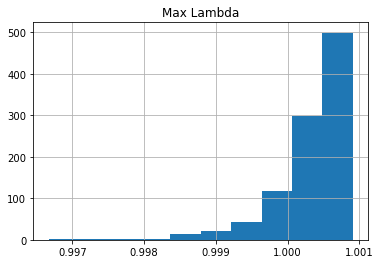

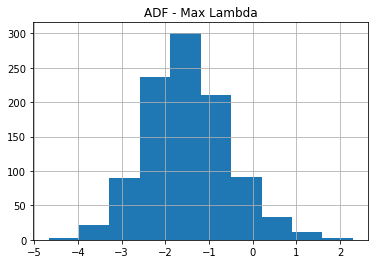

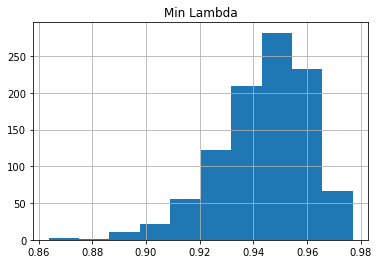

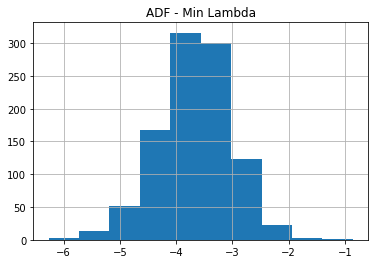

In [39]:
print('simulation for T=1000, N=5')
df=pd.DataFrame(MC_result_1.max_lambda.lambdas,columns=['Max Lambda']).hist()
df=pd.DataFrame(MC_result_1.max_lambda.dickey_fuller,columns=['ADF - Max Lambda']).hist()

df=pd.DataFrame(MC_result_1.min_lambda.lambdas,columns=['Min Lambda']).hist()
df=pd.DataFrame(MC_result_1.min_lambda.dickey_fuller,columns=['ADF - Min Lambda']).hist()

simulation for T=1000, N=30


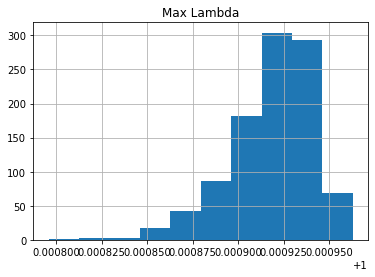

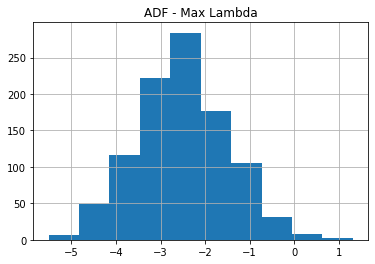

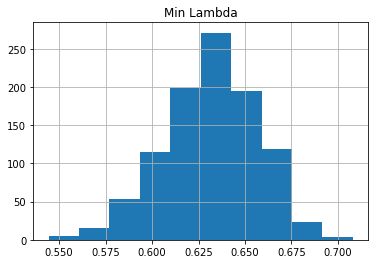

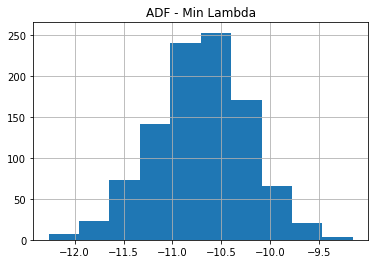

In [40]:
print('simulation for T=1000, N=30')
df=pd.DataFrame(MC_result_2.max_lambda.lambdas,columns=['Max Lambda']).hist()
df=pd.DataFrame(MC_result_2.max_lambda.dickey_fuller,columns=['ADF - Max Lambda']).hist()

df=pd.DataFrame(MC_result_2.min_lambda.lambdas,columns=['Min Lambda']).hist()
df=pd.DataFrame(MC_result_2.min_lambda.dickey_fuller,columns=['ADF - Min Lambda']).hist()

Looking at the Dickey-Fuller results, the results for the trending relationships (max λ) do not look impressive at all. However, the stationary relationships (min λ) look very promising, about -3.5 for N = 5, and about -10.5 for N = 30, for T=1000. A result of Dickey-Fuller of -3.5 is already 99% confidence on stationarity, -10.5 is a virtual certainty that S is stationary. However, we were not supposed to be able to build a stationary linear combination, remember that the linear combination of the constituent unit root processes is again a unit root process, which is non-stationary.

In simple terms, if we observe a λ result for Brownian motions that should not be stationary/trending then when we apply BTCD to real data, using the same model used to run the Monte Carlo simulations, we should observe a smaller/larger λ to take our result seriously, otherwise, we are overfitting to noise. The CDF will tell us how small/large λ should be so that we don’t reject the result.

### Cumulative Distribution Function

What we will do now is use these results for λ and get a CDF (cumulative distribution function) so that we can assign probabilities to the values of λ depending on our model. The CDF (cumulative distribution function) is such that if we input a value for λ it will return a probability associated with it, it is an increasing function, so larger λ means larger probability as per the CDF. This is where the number of trials in our Monte Carlo simulation “n_MC” comes into play, larger numbers of trials will create a better approximation to the true CDF. In practice, given some model settings, we will need to calculate the probability that the resulting “S” is stationary or trending.

To do this we will wrap our Monte Carlo simulation and the CDFs from the last sections inside a class so that we can store the results and reuse them nicely and simply.the CDF is an increasing function, this sometimes leads to somewhat confusing probabilities. For some statistical tests, a low p-value is actually what you are looking for, but for others, a large p-value is what you need to look for.

We are going to simplify this and make it more intuitive, assigning two types for the probability calculation, “stationary” and “trending”. For “stationary” probability lower values of λ actually result in higher probabilities for the series being stationary. For the “trending” probability higher values of λ mean higher probabilities of being trending. In any case, we get the probability of being either stationary or trending and we don’t have to remember if low p-values were a good thing or a bad thing. Note that to calculate “stationary” probabilities we use min λ simulation results, while we use max λ simulation results for “trending” probabilities.

In [22]:
from sklearn.linear_model import LinearRegression, ElasticNet
import numpy as np

# define RegressionModel concrete implementation
ols = LinearRegression()

# instantiate BTCDProbTable with desired settings
prob_table_ols = bt.BTCDProbTable(
    T=1_000, N=9, max_lag=1, regression_model=ols, n_MC=1_000
)

# define RegressionModel concrete implementation
elastic_net = ElasticNet(max_iter=10_000)

# instantiate BTCDProbTable with desired settings
prob_table_elastic = bt.BTCDProbTable(
    T=1_000, N=9, max_lag=1, regression_model=elastic_net, n_MC=1_000
)

# run the simulations (this is where you go for the cup of cofee)
prob_table_ols.run_simulation()
prob_table_elastic.run_simulation()

# outputs scalars if the input is scalar
prob_stationary_scalar = prob_table_ols.get_prob(0.9, "stationary")
prob_trending_scalar = prob_table_ols.get_prob(1.0, "trending")

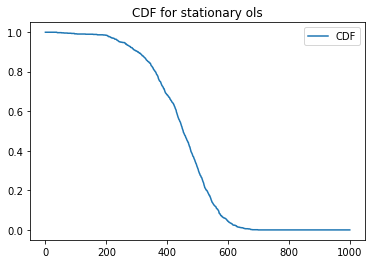

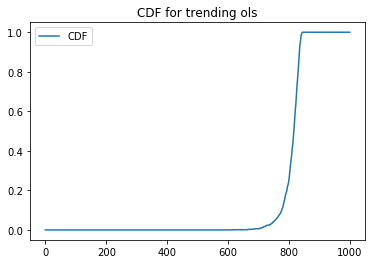

In [46]:
# outputs arrays if the input is array
# define arrays for lambda intervals and get corresponding arrays of probabilities
lambdas_stationary_ols = np.linspace(0.8, 1.0, 1_000)
probs_stationary_ols = prob_table_ols.get_prob(
    lambdas_stationary_ols, "stationary"
)

lambdas_trending_ols = np.linspace(0.995, 1.002, 1_000)
probs_trending_ols = prob_table_ols.get_prob(
    lambdas_trending_ols, "trending"
    )

d=pd.DataFrame(probs_stationary_ols, columns=['CDF']).plot(title='CDF for stationary ols')
d=pd.DataFrame(probs_trending_ols, columns=['CDF']).plot(title='CDF for trending ols')

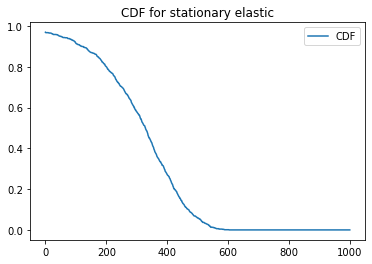

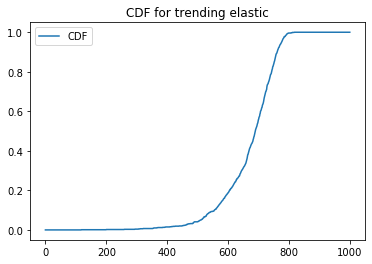

In [47]:
lambdas_stationary_elastic = np.linspace(0.8, 1.0, 1_000)
probs_stationary_elastic = prob_table_elastic.get_prob(
    lambdas_stationary_elastic, "stationary"
)

lambdas_trending_elastic = np.linspace(0.995, 1.002, 1_000)
probs_trending_elastic = prob_table_elastic.get_prob(
    lambdas_trending_elastic, "trending")

d=pd.DataFrame(probs_stationary_elastic, columns=['CDF']).plot(title='CDF for stationary elastic')
d=pd.DataFrame(probs_trending_elastic, columns=['CDF']).plot(title='CDF for trending elastic')